In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import json
import itertools
import re
import random

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.plotly as py
import plotly.graph_objs as go

from datetime import date, timedelta
from skimage.draw import ellipse
from textwrap import wrap
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import HTML, Image
from plotly import tools
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

plt.style.use('seaborn-white')
%matplotlib inline
init_notebook_mode(connected=True)

 # 1. Get to know the data

First step is to download database. Updates are made on a daily basis. Sometimes there could be an additional column that should not be in databases. It is not a big deal and can be corrected by the code below.

In [2]:
# read csv file
# 12 columns that should be in database 
columns = ['video_id', 'title', 'channel_title', 'category_id',
          'tags', 'views', 'likes', 'dislikes', 'comment_total',
          'thumbnail_link', 'date']

gb_vid_df =  pd.read_csv("input/GBvideos.csv", usecols = columns)
us_vid_df =  pd.read_csv("input/USvideos.csv", usecols = columns)

# find out errors in last columns
print (gb_vid_df['date'].unique())
print (us_vid_df['date'].unique())

# replace error items
gb_vid_df.loc[gb_vid_df['date'] == '24.09l7yxJDFvTRM', 'date'] = '24.09'
us_vid_df.loc[us_vid_df['date'] == '24.09xcaeyJTx4Co', 'date'] = '24.09'
gb_vid_df.loc[gb_vid_df['date'] == '26.09t2oVUxTV4WA', 'date'] = '26.09'
us_vid_df.loc[us_vid_df['date'] == '26.0903jeumSTSzc', 'date'] = '26.09'
us_vid_df.loc[us_vid_df['date'] == '100', 'date'] = '09.10'

['13.09' '14.09' '15.09' '16.09' '17.09' '18.09' '19.09' '20.09' '21.09'
 '22.09' '23.09' '24.09' '24.09l7yxJDFvTRM' '25.09' '26.09'
 '26.09t2oVUxTV4WA' '27.09' '28.09' '29.09' '30.09' '01.10' '02.10' '03.10'
 '04.10' '05.10' '06.10' '07.10' '08.10' '09.10' '10.10' '11.10' '12.10'
 '13.10' '14.10' '15.10' '16.10' '17.10' '18.10' '19.10' '20.10' '21.10'
 '22.10']
['13.09' '14.09' '15.09' '16.09' '17.09' '18.09' '19.09' '20.09' '21.09'
 '22.09' '23.09' '24.09' '24.09xcaeyJTx4Co' '25.09' '26.09'
 '26.0903jeumSTSzc' '27.09' '28.09' '29.09' '30.09' '01.10' '02.10' '03.10'
 '04.10' '05.10' '06.10' '07.10' '08.10' '09.10' '100' '10.10' '11.10'
 '12.10' '13.10' '14.10' '15.10' '16.10' '17.10' '18.10' '19.10' '20.10'
 '21.10' '22.10']


Change of data format will make many things easier in the future. Also databases could contain doubles that are better to be removed.

In [3]:
# change format of date table for further operations
gb_vid_df['date'] = gb_vid_df['date'].apply(lambda x: pd.to_datetime(str(x).replace('.','')+"2017",
                                            format='%d%m%Y'))
gb_vid_df['date'] = gb_vid_df['date'].dt.date


us_vid_df['date'] = us_vid_df['date'].apply(lambda x: pd.to_datetime(str(x).replace('.','')+"2017",
                                                                     format='%d%m%Y'))
us_vid_df['date'] = us_vid_df['date'].dt.date

# remove duplicates for GB videos database
gb_vid_df = gb_vid_df.drop_duplicates()
us_vid_df = us_vid_df.drop_duplicates()

gb_vid_df.head(5)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date
0,jt2OHQh0HoQ,Live Apple Event - Apple September Event 2017 ...,Apple Event,28,apple events|apple event|iphone 8|iphone x|iph...,7426393,78240,13548,705,https://i.ytimg.com/vi/jt2OHQh0HoQ/default_liv...,2017-09-13
1,AqokkXoa7uE,Holly and Phillip Meet Samantha the Sex Robot ...,This Morning,24,this morning|interview|holly willoughby|philli...,494203,2651,1309,0,https://i.ytimg.com/vi/AqokkXoa7uE/default.jpg,2017-09-13
2,YPVcg45W0z4,My DNA Test Results! I'm WHAT?!,emmablackery,24,emmablackery|emma blackery|emma|blackery|briti...,142819,13119,151,1141,https://i.ytimg.com/vi/YPVcg45W0z4/default.jpg,2017-09-13
3,T_PuZBdT2iM,getting into a conversation in a language you ...,ProZD,1,skit|korean|language|conversation|esl|japanese...,1580028,65729,1529,3598,https://i.ytimg.com/vi/T_PuZBdT2iM/default.jpg,2017-09-13
4,NsjsmgmbCfc,Baby Name Challenge!,Sprinkleofglitter,26,sprinkleofglitter|sprinkle of glitter|baby gli...,40592,5019,57,490,https://i.ytimg.com/vi/NsjsmgmbCfc/default.jpg,2017-09-13


Now it is possible to make first overall analysis. What I am interested in is to support my understanding of database nature (top 200 trending videos per each day), check how many days a video can be in trend and get some details on longest trending videos.

First function is made to provide quick overall look on the data.

In [4]:
# dataframe to see videos per each date
def quick_insight(df, country, color):
    # dataframes for videos per each date
    vid_check = df[['video_id', 'date']].copy().groupby('date', as_index = False).count()
    vid_check.columns = ['Dates', 'Videos per date']
    
    # dataframes for 
    dates_per_id = df[['video_id', 'date']].groupby('video_id', as_index = False).count()
    dates_per_vids = dates_per_id.groupby('date', as_index = False).count()
    dates_per_vids.columns = ['Quantity of dates per video', 'Quantity of videos in a date group']
    max_days = max(dates_per_vids['Quantity of dates per video'].values)
    
    # videos appeared in database as at 13 September 2017
    sept_13_id = df.loc[df['date'] == date(2017,9,13), 'video_id'].tolist()
    sept_13 = df.loc[df['video_id'].isin(sept_13_id), ['video_id', 'date']]
    sept_13 = sept_13.groupby('date', as_index=False).count()   
    
    # combined plot
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios = [1,0.1,1])
    
    # plotting videos per each date
    ax1 = plt.subplot(gs[2,0:2])
    ax1 = sns.barplot(x="Dates", y="Videos per date", data=vid_check, color='green', alpha=0.8)
    ax1.set_ylabel('Videos per date', fontsize=12)
    ax1.set_xticklabels(vid_check['Dates'].unique(), rotation=45)
    ax1.set_xlabel('')
    ax1.set_title('Videos per each date ({})'.format(country), fontsize=15)
    
    # plotting buckets of videos by quantity of trending dates
    ax2 = plt.subplot(gs[0,0])
    ax2 = sns.barplot(x="Quantity of dates per video",
                      y="Quantity of videos in a date group",
                      data=dates_per_vids, color=color)
    ax2.set_ylabel('Quantity of videos in a date group', fontsize=12)
    ax2.set_xlabel('Quantity of trending days in a bucket', fontsize=12)
    t_str = u'Buckets of videos by quantity of trending dates ({})'
    title = '\n'.join(wrap(t_str.format(country),30))
    ax2.set_title(title, fontsize=15)
    
    # plotting story of videos that appeared on September 13
    ax3 = plt.subplot(gs[0,1])    
    ax3 = sns.barplot(x='date', y="video_id", data=sept_13, color=color, alpha = 0.7)
    ax3.set_ylabel('Quantity of videos per date', fontsize=12)
    ax3.set_xticklabels(sept_13['date'], rotation=45)
    ax3.set_xlabel('')
    t_str = u'Videos started at 13 September ({})'
    title = '\n'.join(wrap(t_str.format(country),20))
    ax3.set_title(title, fontsize=15)
    
    plt.show()

The second function is designed to give deeper information of what videos were in trend for longest period. It is interesting can I find there some familiar videos? How many and what dynamics of views, likes, dislikes and comments are required to become trending video? Are there some similarities in preferences of US and GB audience?

In [5]:
def best_survivors(df, days, country):
    # videos with selected lifetime in top 200
    dates_per_id = df[['video_id', 'date']].groupby('video_id', as_index = False).count()
    long_surv_list = dates_per_id.loc[dates_per_id['date'] == days,'video_id'].tolist()
    long_surv_vid = df.loc[df['video_id'].isin(long_surv_list),
                           ['title','date','views','likes','dislikes','comment_total']]
    long_surv_vid['views'] = long_surv_vid['views'].apply(lambda x: x/1000000)
    titles_list = long_surv_vid['title'].unique().tolist()

    # plotting videos views history
    views = []
    likes = []
    dislikes = []
    comments = []
    plots_list = [views, likes, dislikes, comments]
    column_list = ['views', 'likes', 'dislikes', 'comment_total']
    boolean_list = [False, False, False, True]
    colors_list = []
    for i in range(0,len(titles_list)):
        color = 'rgb('+str(np.random.randint(1,256))+","+str(np.random.randint(1,256))+","+str(np.random.randint(1,256))+")"
        colors_list.append(color)
    
    for x in range (0,len(plots_list)):
        for i in range (0, len(titles_list)):
            vt = titles_list[i]
            trace = go.Scatter(x = long_surv_vid.loc[long_surv_vid['title']== vt,'date'],
                                y = long_surv_vid.loc[long_surv_vid['title']== vt, column_list[x]],
                                name = vt,
                                line = dict(width = 2, color = colors_list[i]),
                                legendgroup = vt,
                                showlegend = boolean_list[x])
    
            plots_list[x].extend([trace])
    
    fig = tools.make_subplots(rows=4,
                              cols=1, 
                              subplot_titles=('Views', 'Comments', 'Likes', 'Dislikes'),
                              vertical_spacing=0.07)
    
    for i in views:
        fig.append_trace(i, 1, 1)
    for i in comments:
        fig.append_trace(i, 2, 1)
    for i in likes:
        fig.append_trace(i, 3, 1)
    for i in dislikes:
        fig.append_trace(i, 4, 1)
    
    fig['layout']['xaxis1'].update(title='')
    fig['layout']['xaxis2'].update(title='')
    fig['layout']['xaxis3'].update(title='')
    fig['layout']['xaxis4'].update(title='')

    fig['layout']['yaxis1'].update(title='mln. views')
    fig['layout']['yaxis2'].update(title='comments')
    fig['layout']['yaxis3'].update(title='likes')
    fig['layout']['yaxis4'].update(title='dislikes')
    
    fig['layout'].update(width=800, height=(1000 + len(titles_list)*60))
    fig['layout'].update(title='Different metrics for videos trended in {} for {} days'.format(country, days))
    fig['layout'].update(legend = dict(x=0.0,
                                       y = -(0.1+len(titles_list)*0.007),
                                      tracegroupgap = 1))

    iplot(fig, filename='customizing-subplot-axes')

* Now both functions can be applied to GB and US database.

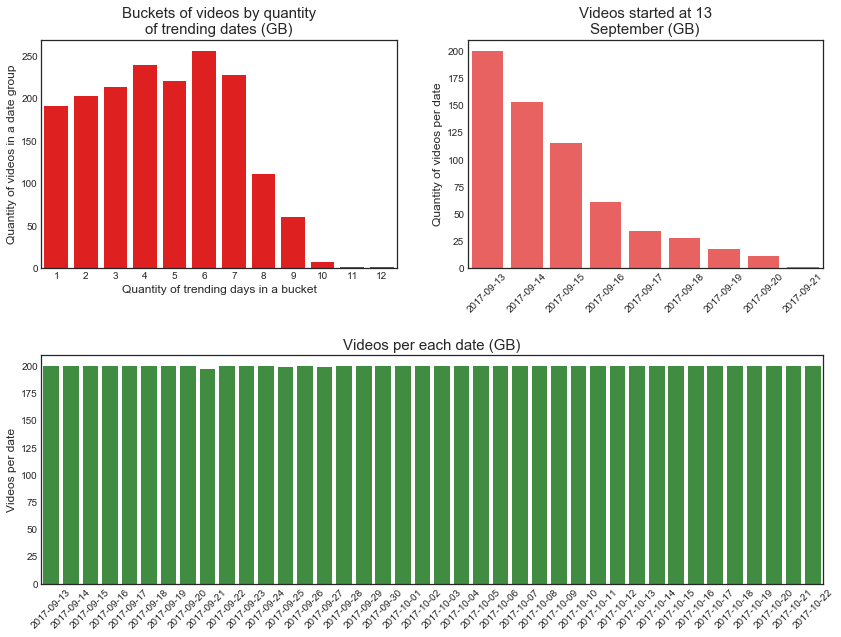

In [6]:
quick_insight(gb_vid_df, "GB", 'red')

In [7]:
best_survivors(gb_vid_df, 10, "GB")

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



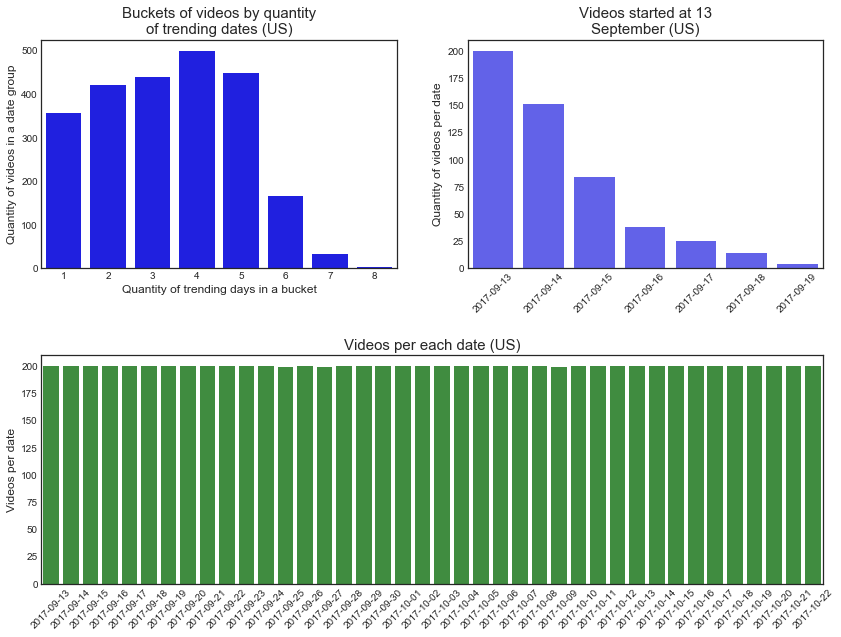

In [8]:
quick_insight(us_vid_df, "US", 'blue')

In [9]:
best_survivors(us_vid_df, 7, "US")

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



Some initial conclusions:

There are 200 trending videos per each date. Database does not look for some specific videos, only for top 200 trending. Video may be in this top list for a few days or only one day.

Within covered period GB audience showed higher adherence to trending videos. Maximum amount of days being in trend for US audience was 7 days and for GB it was 10 days.

Plotly charts above are very convenient, as it is possible to click on some videos in legend to exclude it from the charts. Thus if you interested in some specific video(s) it is possible to leave only them to look at.

This method also reveal that in most cases likes and dislikes have similar shapes but different magnitudes.

What is puzzling me now is why some of the top trending videos have so low amount of views/comments. I suppose that trending is more about speed of new views than they amont. Thus in following analysis I plan do check dynamic of these features for trending videos.

# 2. Trending channels

The questions I have are:

* how US and GB trending longevity of channels compares?
* what is the difference in lasting trends between US and GB?
* how average trend of likes and comments for each longevity group looks like?
* are there channels that reappear in top 200?
* what are the features of stable-trending channels (category, tags, ratio of views to likes/comments)?

In [10]:
# function designed to plot longevity of trending
def trending_channels(gb, us, day_start, day_end, fig_height, hr_2ndRow):
    # list of selected dates
    datelist = [day_start + timedelta(days=x) for x in range((day_end-day_start).days + 1)]
    # number of days is selected time span
    tr_days = len(datelist)
    
    # leave only dates within selected range
    gb = gb.loc[gb['date'].isin(datelist),]
    us = us.loc[us['date'].isin(datelist),]
    
    # Dataframes for longeivety plot -----------------------------------------------------
    # group by channel title to see for how many dates channel was in trend
    gb_ch_days = gb.groupby('channel_title')['date'].nunique()
    gb_ch_days = gb_ch_days.to_frame().reset_index()
    # dataframe with amount of channels per each "days in trend" bucket
    gb_days_trending = gb_ch_days.groupby('date', axis=0, as_index = False).count()
    
    # group by channel title to see for how many dates channel was in trend
    us_ch_days = us.groupby('channel_title')['date'].nunique()
    us_ch_days = us_ch_days.to_frame().reset_index()
    # dataframe with amount of channels per each "days in trend" bucket
    us_days_trending = us_ch_days.groupby('date', as_index = False).count()  
    
    # Difference in trending channels in US and GB -----------------------------------------
    gb_day_tr_list = gb_ch_days.loc[gb_ch_days['date']==tr_days,
                                    'channel_title'].values.tolist()
    gb_day_tr = gb.loc[gb['channel_title'].isin(gb_day_tr_list),]
    gb_day_tr = gb_day_tr.loc[gb_day_tr['date'].isin(datelist),]
    gb_day_tr.sort_values('date', axis=0, ascending=True, inplace=True)
    gb_day_tr.drop_duplicates(subset='video_id', keep='last', inplace=True)
    gb_day_summary = gb_day_tr[['channel_title', 'views']].copy().groupby('channel_title',
                                                                  as_index = False).sum()
    
    us_day_tr_list = us_ch_days.loc[us_ch_days['date']==tr_days,
                                    'channel_title'].values.tolist()
    us_day_tr = us.loc[us['channel_title'].isin(us_day_tr_list),]
    us_day_tr = us_day_tr.loc[us_day_tr['date'].isin(datelist),]
    us_day_tr.sort_values('date', axis=0, ascending=True, inplace=True)
    us_day_tr.drop_duplicates(subset='video_id', keep='last', inplace=True)
    us_day_summary = us_day_tr[['channel_title', 'views']].copy().groupby('channel_title',
                                                                  as_index = False).sum()
    
    # make lists of channels overlap and channels for gb/us only --------------------------
    gb_tr_list = gb_day_summary['channel_title'].values.tolist()
    us_tr_list = us_day_summary['channel_title'].values.tolist()
    overlaps = [x for x in gb_tr_list if x in us_tr_list]
    gb_only = [x for x in gb_tr_list if x not in us_tr_list]
    us_only = [x for x in us_tr_list if x not in gb_tr_list]
    
    # sort dataframes to make plots look nicer
    gb_day_summary.sort_values('views', axis=0, ascending=False, inplace=True)
    us_day_summary.sort_values('views', axis=0, ascending=False, inplace=True)
    
    # make overlap database and sort them by channel_title
    gb_overlap = gb_day_summary.loc[gb_day_summary['channel_title'].isin(overlaps),]
    gb_overlap = gb_overlap.sort_values('channel_title', axis=0, ascending=False)
    
    us_overlap = us_day_summary.loc[us_day_summary['channel_title'].isin(overlaps),]
    gb_overlap = us_overlap.sort_values('channel_title', axis=0, ascending=False)
    
    # make us/gb only database
    gb_only_df = gb_day_summary.loc[gb_day_summary['channel_title'].isin(gb_only),]
    us_only_df = us_day_summary.loc[us_day_summary['channel_title'].isin(us_only),]  
    
    # combined plot ------------------------------------------------------------------
    fig = plt.figure(figsize=(12, fig_height))
    gs = gridspec.GridSpec(3, 6, height_ratios=[1,0.1,hr_2ndRow],
                           width_ratios=[1,1,1,0.5,1,1])
    
    # plotting longevity of trending
    ax1 = plt.subplot(gs[0,:3])
    ax1.bar(gb_days_trending['date']+0.15,
            gb_days_trending['channel_title'],
            width = 0.35,
            color='r', alpha = 1)
    ax1.bar(us_days_trending['date']-0.15,
            us_days_trending['channel_title'],
            width = 0.35,
            color='b', alpha = 1)
    
    ax1.set_title('Longevity of trending from {} to {}'.format(day_start,day_end),
                fontstyle='italic', fontweight='bold')
    ax1.set_ylabel('Channels within each bucket')
    ax1.set_yticks(np.arange(0, max(us_days_trending['channel_title']), 10))
    ax1.set_xlabel('Days channel was in list of top 200 trending videos')
    ax1.set_xticks(us_days_trending['date'].unique())
    ax1.set_xticklabels(gb_days_trending['date'].unique())
    ax1.legend(('GB', 'US'))
    ax1.grid(linestyle='-', linewidth=1)
    
    # plotting channels trending in both GB and US
    ax2 = plt.subplot(gs[0,4:])
    width = 0.4
    ax2.barh(np.arange(gb_overlap['channel_title'].shape[0]),
             gb_overlap['views'].apply(lambda x: x/1000000),
             width, color='r', alpha = 1)
    ax2.barh(np.arange(us_overlap['channel_title'].shape[0])+width,
             us_overlap['views'].apply(lambda x: x/1000000),
             width, color='b', alpha = 1)
    overlaps = [ '\n'.join(wrap(l, 15)) for l in overlaps]
    ax2.set_yticks(np.arange(len(overlaps)))
    yticklabels = ['\n'.join(wrap(l, 15)) for l in us_overlap['channel_title'].values.tolist()]
    ax2.set_yticklabels(yticklabels, stretch = 'ultra-condensed')
    ax2.set_xlabel('mln viewes')
    ax2.legend(('GB', 'US'))
    t_str = u'Channels trended in GB and US for {} days from {} to {}'
    title = '\n'.join(wrap(t_str.format(tr_days,day_start, day_end),30))
    ax2.set_title(title, fontstyle='italic', fontweight='bold')
    
    # plotting channels trending in GB only
    ax3 = plt.subplot(gs[2,:2])
    width = 0.3
    ax3 = sns.barplot(x = gb_only_df['views'].apply(lambda x: x/1000000),
                     y = gb_only_df['channel_title'],
                     color = 'red')
    gb_only = ['\n'.join(wrap(l, 15)) for l in gb_only]
    ax3.set_yticks(np.arange(len(gb_only)))
    ax3.set_yticklabels(gb_only_df['channel_title'],stretch = 'ultra-condensed')
    ax3.set_xlabel('mln viewes')
    ax3.set_ylabel('')
    t_str = u'Channels trended only in GB for {} days from {} to {}'
    title = '\n'.join(wrap(t_str.format(tr_days,day_start, day_end),30))
    ax3.set_title(title, fontstyle='italic', fontweight='bold')
    
    # plotting channels trending in US only
    ax4 = plt.subplot(gs[2,4:])
    width = 0.3
    ax4 = sns.barplot(x = us_only_df['views'].apply(lambda x: x/1000000),
                     y = us_only_df['channel_title'],
                     color = 'blue')
    us_only = ['\n'.join(wrap(l, 15)) for l in us_only]
    ax4.set_yticks(np.arange(len(us_only)))
    ax4.set_yticklabels(us_only_df['channel_title'], stretch = 'ultra-condensed')
    ax4.set_xlabel('mln viewes')
    ax4.set_ylabel('')
    t_str = u'Channels trended only in US for {} days from {} to {}'
    title = '\n'.join(wrap(t_str.format(tr_days,day_start, day_end),30))
    ax4.set_title(title, fontstyle='italic', fontweight='bold')
    
    plt.show()

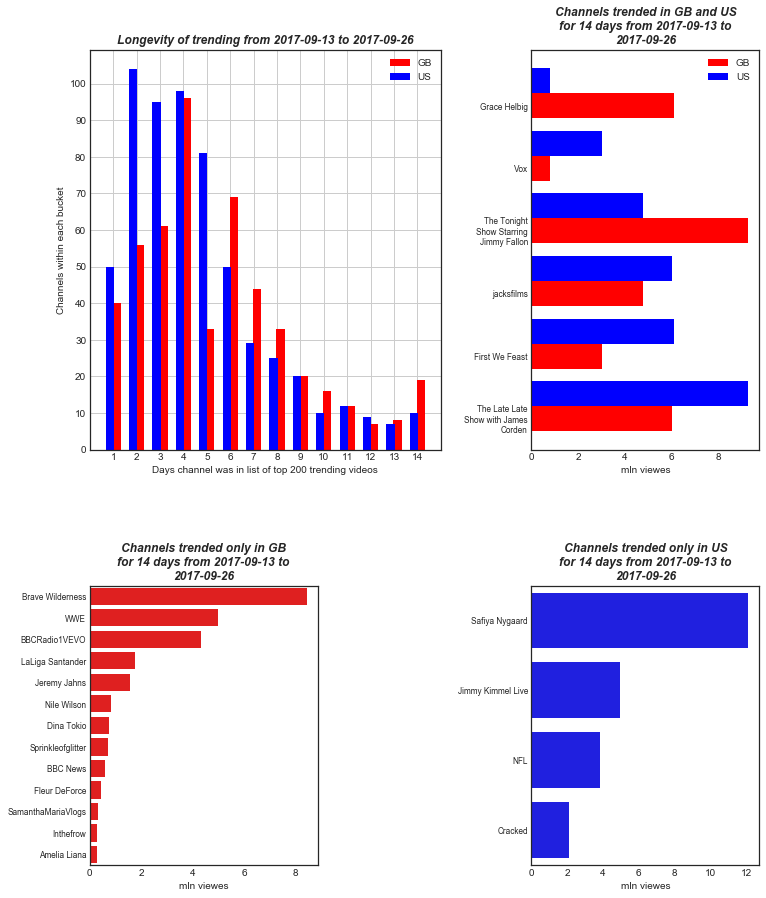

In [11]:
trending_channels(gb_vid_df, us_vid_df, date(2017,9,13), date(2017,9,26), 15, 0.7)

The charts above tell the following: 
* there were 19 channels with videos trending in GB for all 14 days selected
* there were 10 channels with videos trending in US for all 14 days selected
* the chart is not cumulative - the channels from bucket "15 days" don't appear in other buckets
* 6 channels were in top trends in both countries
* 13 channels were in top trends in GB only 
* 4 channels were in top trends in US only
* if your target audience is US then much more effort should be made to keep the channel in top trends

At first I expected that it is possible that one channel includes few trending videos at same date. But it appeared not to be so. Following chart supports this conclusion.

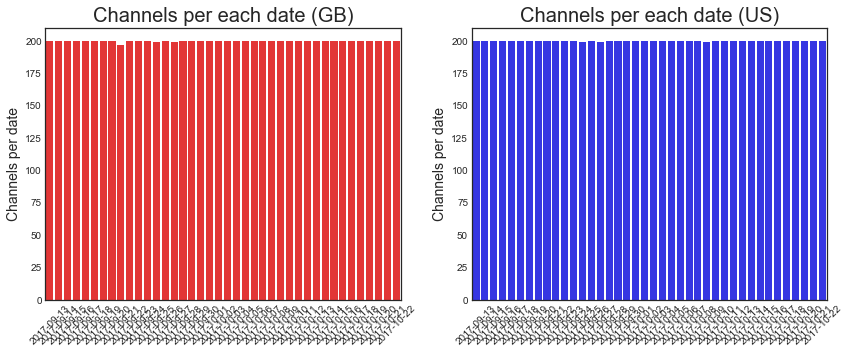

In [12]:
gb_chan_per_date = gb_vid_df[['channel_title', 'date']].groupby('date', 
                                                                as_index=False).count()

us_chan_per_date = us_vid_df[['channel_title', 'date']].groupby('date', 
                                                                as_index=False).count()

# plotting quantity of channels per each date
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])

ax1 = plt.subplot(gs[0,0])
ax1 = sns.barplot(x="date", y="channel_title", data=gb_chan_per_date,
                  color='red', alpha=0.9)
ax1.set_ylabel('Channels per date', fontsize=14)
ax1.set_xticklabels(gb_chan_per_date['date'].unique(), rotation=45)
ax1.set_xlabel('')
ax1.set_title('Channels per each date (GB)', fontsize=20)

ax2 = plt.subplot(gs[0,1])
ax2 = sns.barplot(x="date", y="channel_title", data=us_chan_per_date,
                  color='blue', alpha=0.9)
ax2.set_ylabel('Channels per date', fontsize=14)
ax2.set_xticklabels(us_chan_per_date['date'].unique(), rotation=45)
ax2.set_xlabel('')
ax2.set_title('Channels per each date (US)', fontsize=20)

plt.show()

These two looks very familiar to charts above with **videos** by each date. But this one shows **channels** by each date. Thus amount of videos per day equals to amount of channels per day which means only one videos from the channel can be in trend. 

Considering this conclusion it is interesting to see what happens with videos of trending channels. At what point one is replaced by another.

Function below is designed to make Ploly chart with possibility to select specific channel and explore the story of its videos.

In [13]:
# function for channels analysis
# days_a must be in range between day_start and day_end
def channels_insight(df, country, day_start, day_end, days_a):
    # list of selected dates
    datelist = [day_start + timedelta(days=x) for x in range((day_end-day_start).days + 1)]
    # take part of database that included in relevant period
    df = df.copy().loc[df['date'].isin(datelist),]
    # make list of channels survived for selected days_a
    df_ch_days = df.groupby('channel_title')['date'].nunique().to_frame().reset_index()
    df_ch_list = df_ch_days.loc[df_ch_days['date']==days_a, 'channel_title'].unique().tolist()
    
    # plotting videos per each channel (by views)
    data = []
    buttons = []
    buttons_list = []
    
    for x in df_ch_list:
        channel_videos = df.loc[df['channel_title'] == x,['title', 'date', 'views']]
        videos_list = channel_videos['title'].unique().tolist()
        boolean_list = [True] + [False]*(len(videos_list)-1)
        color = 'rgb('+str(np.random.randint(1,256))+","+str(np.random.randint(1,256))+","+str(np.random.randint(1,256))+")"
        for i in range(0,len(videos_list)):
            vt = videos_list[i]
            video = channel_videos.loc[channel_videos['title']==vt, ['views', 'date']]
            trace = go.Scatter(x = video['date'].values,
                               y = video['views'].values,
                               name = x,
                               line = dict(width = 2, color = color),
                               legendgroup = x,
                               showlegend = boolean_list[i])
            buttons_list.append(x) # this list will help identify buttons visibility
            data.extend([trace])
    
    for x in df_ch_list:       
        buttons_upd = list([dict(label = x,
                                method = 'update',
                                args = [{'visible': [i==x for i in buttons_list]}])])
        buttons.extend(buttons_upd)
    
    buttons_all = list([dict(label = 'All channels',
                             method = 'update',
                             args = [{'visible': [True for x in buttons_list]}])]) 

    buttons.extend(buttons_all)
    
    update_menus = list([dict(active=1,
                              buttons = buttons,
                              direction = 'down',
                              pad = {'r': 10, 't': 10},
                              showactive = True,
                              x = 0.001,
                              xanchor = 'left',
                              y = 1.1,
                              yanchor = 'top')])
    
    layout = dict(title = 'Videos of trending channels ({})'.format(country),
                  xaxis = dict(title = ''),
                  yaxis = dict(title = 'views'),
                  updatemenus = update_menus,
                  width=800, height=600, legend=dict(orientation="h"))
         
    fig = dict(data = data, layout = layout)
    
    iplot(fig)

In [14]:
channels_insight(gb_vid_df, "GB", date(2017,9,13), date(2017,9,24), 12)

In [15]:
channels_insight(us_vid_df, "US", date(2017,9,13), date(2017,9,24), 12)

The best way to see the situation with 1 trending video per 1 trending channel is to select The Tonight Show Starring Jimmy Fallon for both countries.

Each has 7 videos per selected period. Sometimes it is only one day for a video to be in trends. Then other video of the channel replaces it in top 200. This looks very irrational. Why can't two or more videos of the one channel be in trend? Well, it is something I will try to find out using this database or other sources.

Also, what is clear now is that trending doesn't relay solely on views. Dynamic must be more important that row number of views.

> # 3. Analysis by categories

Categories will help to better understand nature of channels. They can be retreived from JSON file.

In [16]:
# dictionary for GB database
with open('input/GB_category_id.json') as json_data:
    gb_from_json = json.load(json_data)
gb_prelim_dict = gb_from_json['items']
json_data.close()

gb_cat_dict = {}
for i in range (0,len(gb_prelim_dict)):
    cat_key = int(gb_prelim_dict[i]['id'])
    cat_item = gb_prelim_dict[i]['snippet']['title']
    gb_cat_dict[cat_key] = cat_item
gb_cat_dict[29] = 'Schools & Hospitals'
    
# dictionary for US database
with open('input/GB_category_id.json') as json_data:
    us_from_json = json.load(json_data)
us_prelim_dict = us_from_json['items']
json_data.close()

us_cat_dict = {}
for i in range (0,len(us_prelim_dict)):
    cat_key = int(us_prelim_dict[i]['id'])
    cat_item = us_prelim_dict[i]['snippet']['title']
    us_cat_dict[cat_key] = cat_item
gb_cat_dict[29] = 'Schools & Hospitals'

# addition of categories to both databases
gb_vid_df['category_name'] = gb_vid_df['category_id'].apply(lambda x: gb_cat_dict[x])
gb_vid_df.head(5)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_total,thumbnail_link,date,category_name
0,jt2OHQh0HoQ,Live Apple Event - Apple September Event 2017 ...,Apple Event,28,apple events|apple event|iphone 8|iphone x|iph...,7426393,78240,13548,705,https://i.ytimg.com/vi/jt2OHQh0HoQ/default_liv...,2017-09-13,Science & Technology
1,AqokkXoa7uE,Holly and Phillip Meet Samantha the Sex Robot ...,This Morning,24,this morning|interview|holly willoughby|philli...,494203,2651,1309,0,https://i.ytimg.com/vi/AqokkXoa7uE/default.jpg,2017-09-13,Entertainment
2,YPVcg45W0z4,My DNA Test Results! I'm WHAT?!,emmablackery,24,emmablackery|emma blackery|emma|blackery|briti...,142819,13119,151,1141,https://i.ytimg.com/vi/YPVcg45W0z4/default.jpg,2017-09-13,Entertainment
3,T_PuZBdT2iM,getting into a conversation in a language you ...,ProZD,1,skit|korean|language|conversation|esl|japanese...,1580028,65729,1529,3598,https://i.ytimg.com/vi/T_PuZBdT2iM/default.jpg,2017-09-13,Film & Animation
4,NsjsmgmbCfc,Baby Name Challenge!,Sprinkleofglitter,26,sprinkleofglitter|sprinkle of glitter|baby gli...,40592,5019,57,490,https://i.ytimg.com/vi/NsjsmgmbCfc/default.jpg,2017-09-13,Howto & Style


The section is in progress...

# 4. Views, likes, dislikes and comments

In [17]:
gb_vid_df.rename(columns={'comment_total':'comments'}, inplace=True)
us_vid_df.rename(columns={'comment_total':'comments'}, inplace=True)

There must be a strong positive correlation between views and all other feature (comments, likes, dislikes). The logic behind is simple: more views - more expression of opinion in any of its form.

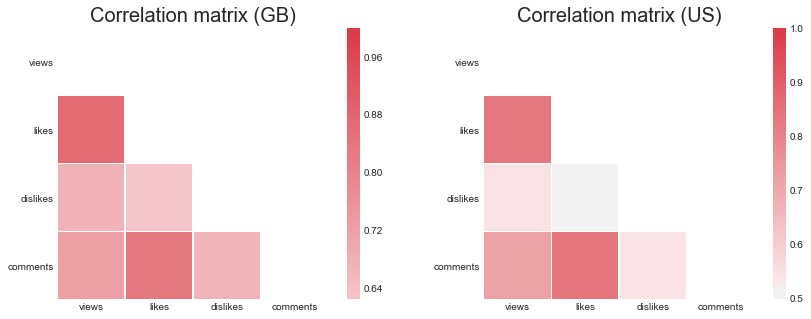

In [18]:
corr_gb = gb_vid_df.loc[:,['views', 'likes', 'dislikes', 'comments']].corr()
corr_us = us_vid_df.loc[:,['views', 'likes', 'dislikes', 'comments']].corr()

mask = np.zeros_like(corr_gb, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax1 = plt.subplot(gs[0,0])
ax1 = sns.heatmap(corr_gb, cmap=cmap, vmax=1, center=0.5,
            square=True, linewidths=.5, mask=mask)
ax1.set_title('Correlation matrix (GB)', fontsize=20)
plt.yticks(rotation=0)

ax2 = plt.subplot(gs[0,1])
ax1 = sns.heatmap(corr_us, cmap=cmap, vmax=1, center=0.5,
                  square=True, linewidths=.5, mask=mask)
ax2.set_title('Correlation matrix (US)', fontsize=20)
plt.yticks(rotation=0)

plt.show()

For GB segment of YouTube everything is very straightforward - views bring other activities. The US segment is different - dislikes seems to have their own path despite what happens with views, comments and likes. 

Visualization of these features should help a lot. Next part of the code provides functions for plotting views, comments, likes and dislikes for whole period of database. The plot is cumulative. Decreases in trend-line occur when a video with big stats is excluded from the pool of 200.

In [19]:
def vldc_plot(df_init, country):
    df = df_init[['date','views', 'likes',
             'dislikes','comments']].groupby('date', as_index = False).sum()
    df[['views','likes', 'dislikes','comments']] = df[['views', 'likes',
                                                       'dislikes', 'comments']].apply(lambda x: x/1000000)
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1])

    ax1 = plt.subplot(gs[0,0])
    ax1.plot(df['date'], df['views'])
    ax1.set_xticklabels("")
    ax1.set_title('Views, mln', fontsize=20)

    ax2 = plt.subplot(gs[0,1])
    ax2.plot(df['date'], df['comments'])
    ax2.set_xticklabels("")
    ax2.set_title('Comments, mln', fontsize=20)

    ax3 = plt.subplot(gs[1,0])
    ax3.plot(df['date'], df['likes'])
    ax3.set_xticks(df['date'].values)
    ax3.set_xticklabels(df['date'], rotation=45)
    ax3.set_title('Likes, mln', fontsize=20)

    ax4 = plt.subplot(gs[1,1])
    ax4.plot(df['date'], df['dislikes'])
    ax4.set_xticks(df['date'].values)
    ax4.set_xticklabels(df['date'], rotation=45)
    ax4.set_title('Dislikes, mln', fontsize=20)

    plt.suptitle('{} segment'.format(country), fontsize=22)

    plt.show()

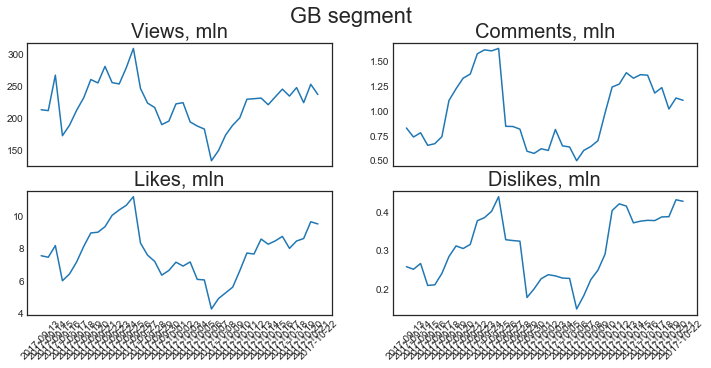

In [20]:
vldc_plot(gb_vid_df, 'GB')

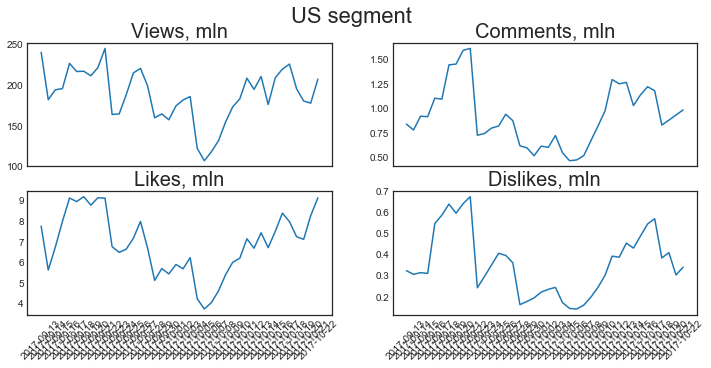

In [21]:
vldc_plot(us_vid_df, 'US')

Week correlation between dislikes and everything else in US segment is mostly guided by 13 September where high views and many likes had relatively small amount of comments and dislikes.  The database is updated regularly and is going to embrace longer period. After some time the correlation will relay less on daily data.

In [22]:
us_vid_df_corr_check = gb_vid_df.loc[gb_vid_df['date']!=date(2017,9,13),]
corr_us = us_vid_df_corr_check.loc[:,['views', 'likes', 'dislikes', 'comments']].corr()
corr_us

,views,likes,dislikes,comments
views,1.000000,0.863980,0.673084,0.723835
likes,0.863980,1.000000,0.625403,0.838232
dislikes,0.673084,0.625403,1.000000,0.664547
comments,0.723835,0.838232,0.664547,1.000000


Another interesting observation - cumulative amount of views for GB reached over 300 mln. and for US only 240 mln. The first thought is there must be some mistake in code or database - US has bigger YouTube audience than other countries. But first chapter of this analysis gave picture of how long a video is in top 200. In US segment this turnover is higher than in GB's. Thus for GB segment the videos with lots of views stay in top 200 and contribute to total amount of views. At the same time in US segment new videos with less views replace old ones.

# 5. Predicting tags    

Each video has tags. They are made by videos' authors. But maybe we can try to predict them based on comments?
These are the sources of inspiration:

https://www.kaggle.com/c/transfer-learning-on-stack-exchange-tags/kernels

https://web.stanford.edu/class/cs224n/reports/2759891.pdf

https://www.kaggle.com/l3nnys/useful-text-preprocessing-on-the-datasets

The first step is to convert tags from string to list of strings.

In [23]:
gb_vid_df['tags'] = gb_vid_df['tags'].map(lambda x: x.split('|'))
us_vid_df['tags'] = us_vid_df['tags'].map(lambda x: x.split('|'))

There are few rows that have more collumns than they should. Due to insignificant amount it is safe to exclude them.

In [24]:
# downloading the data and skip bad rows
gb_comm_df =  pd.read_csv("input/GBcomments.csv", error_bad_lines = False)
us_comm_df =  pd.read_csv("input/UScomments.csv", error_bad_lines = False)

b'Skipping line 113225: expected 4 fields, saw 5\n'
b'Skipping line 158379: expected 4 fields, saw 7\nSkipping line 241590: expected 4 fields, saw 5\nSkipping line 245637: expected 4 fields, saw 7\n'
b'Skipping line 521402: expected 4 fields, saw 5\n'
b'Skipping line 41589: expected 4 fields, saw 11\nSkipping line 51628: expected 4 fields, saw 7\nSkipping line 114465: expected 4 fields, saw 5\n'
b'Skipping line 142496: expected 4 fields, saw 8\nSkipping line 189732: expected 4 fields, saw 6\nSkipping line 245218: expected 4 fields, saw 7\n'
b'Skipping line 388430: expected 4 fields, saw 5\n'
C:\Users\amans\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.



Comments database containes infromation on same videos. US and GB databases could be combined to provide full picture for any video. 

It is possible a video lasts longer in one database than in the other, but the goal of this part is to predict tags, so it is ok to combine all available information in one place.

In [25]:
# combined database on videos features (will be used for vlookup only)
all_vid_df = gb_vid_df.append(us_vid_df)
all_vid_df.sort_values('date', ascending=False, inplace=True)
# leave only most recent date for each video
all_vid_df.drop_duplicates('video_id', keep = 'first', inplace = True)


# combined database for comments
all_comm_df = gb_comm_df.append(us_comm_df)
# duplicates should be deleted
all_comm_df.drop_duplicates(['video_id', 'comment_text'], keep = 'first', inplace = True)

all_comm_df = all_comm_df.join(all_vid_df.set_index('video_id')[['tags',
                                                               'channel_title',
                                                               'title']], on = 'video_id')
# make additional column for number of tags
all_comm_df['num_tags'] = all_comm_df['tags'].apply(lambda x: len(x))
all_comm_df.shape

(646863, 8)

To make predictions I need to get rid of different artifacts (html characters and emojis) and exclude non-ASCII characters. Following functions should help with this task: 

In [26]:
# function for cleaning urls
def remove_urls(x):
    return re.sub(r"http\S+", "", x)

In [27]:
# function for cleaning text of html tags and uris

# thanks to https://www.kaggle.com/l3nnys/useful-text-preprocessing-on-the-datasets
uri_re = r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

def stripTagsAndUris(x):
    # BeautifulSoup on content
    soup = BeautifulSoup(x, "html.parser")
    # Stripping all <code> tags with their content if any
    if soup.code:
        soup.code.decompose()
    # Get all the text out of the html
    text =  soup.get_text()
    # Returning text stripping out all uris
    return re.sub(uri_re, "", text)

In [28]:
# emoji pattern (https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python)
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

# function for removal of non-ASCII characters and emoji
def exASCII(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    ex_ascii = re.sub(r'[^\x00-\x7f]',r'',x)
    # remove emoji
    return emoji_pattern.sub(r'', ex_ascii)

In [29]:
# replace trippled+ characters
# https://stackoverflow.com/questions/43110237/replace-consecutive-repeated-characters-with-one-column-wise-operation-pand
def trim_trippled(x):
    min_threshold_rep = 3
    return re.sub(r'(.)\1{%d,}'%(min_threshold_rep-1), r'\1',x)

In [30]:
# change shorcuts to full words, replace remains of unwanted characters
# thanks to https://www.analyticsvidhya.com/blog/2014/11/text-data-cleaning-steps-python/
apts = {"'s": " is",
        "'ll": " will",
        "'re": " are",
        "'d": " would",
        "'t": " not",
        "'m": " am",
        "'ve": " have",
        "&": " and ",
        "\*": " ",
        r'\\n': " ",
        '[%_=>#"(--)\)\(:\^~\<( - )( / )([\\\/\])]': " ",
        "[^(\d]\d+\)": " ",
        "([\d|\d\d]):([\d|\d\d])(:([\d|\d\d]))?": " "}

# exclude double spaces left after previous step
rem = {'  +': ' '}

def ex_apts_rem(x):
    for i in apts:
        x = re.sub(i, apts[i], x)
    for i in rem:
        x = re.sub(i, rem[i], x)
    return x

In [31]:
# leave only those words that correspond to selected parts of speech
def nlp_filter(x):
    tokens = nlp(x)
    tags = []
    list_of_tags = ['CD','FW','JJ','JJR','JJS','NN','NNP','NNPS','NNS','RB','RBR','RBS']
    for token in tokens:
        tags.append((token.lemma_, token.tag_))
    filtered_list = [(n,y) for (n,y) in tags if y in list_of_tags]
    x = " ".join([n for (n,y) in filtered_list])
    return x

In [32]:
# function that embraces all previous text preparation process
def preprocess_functions(x):
    return (ex_apts_rem(trim_trippled(exASCII(stripTagsAndUris(remove_urls(x))))))

Now functions above can be applied to comments column.

In [ ]:
# prepare comments section
comments_df = all_comm_df.copy()
comments_df['comment_text'] = comments_df['comment_text'].apply(str)
comments_df['comment_text_proc'] = comments_df['comment_text'].apply(lambda x: preprocess_functions(str(x)))

C:\Users\amans\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning:

"b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

C:\Users\amans\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning:

"b'....'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

C:\Users\amans\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning:

"b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

C:\Users\amans\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning:

"b'.....'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.

C:\Users\amans\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning:

"b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Be

There are handful of videos that are titled, tagged and commented in languages other than English. To simplify the prediction I exclude them using following procedure: 
1.  Create comments column without emojis but with non-ASCII characters.
2. Put all videos that have more than 50% of comments made with non-ASCII characters into special list.
3. Exclude all items these videos from the final set.

Also videos with less than 10 comments were excluded as in most cases they provide insufficient amount of text for prediction. 

In [ ]:
# create comments column where emojis are excluded but other non-ASCII characters are preserved
comments_df['no_emo_comments'] = comments_df['comment_text'].apply(lambda x: emoji_pattern.sub('r', x))

# videos where most of the comments made with non-ASCII characters
vid_list = comments_df['video_id'].unique()
vid_list_nonASCII = []
for i in vid_list:
    temp_df = comments_df.loc[comments_df['video_id'] == i, ]
    nonASCII = temp_df['no_emo_comments'].str.contains('[^\x00-\x7f]').sum() # number of comment with non-ASCII characters
    all_com = temp_df['no_emo_comments'].count() # total number of comments
    if (nonASCII/all_com) > 0.5:
        vid_list_nonASCII.append(i)

vid_list_few_comments = []
for i in vid_list:
    temp_df = comments_df.loc[comments_df['video_id'] == i, ]
    if (temp_df['video_id'].count()) < 10:
        vid_list_few_comments.append(i)

del temp_df

In [ ]:
# exclude videos selected in previous step
vid_list_prunned = [x for x in vid_list if x not in vid_list_nonASCII]
vid_list_prunned = [x for x in vid_list_prunned if x not in vid_list_few_comments]

Predictions are made with TfidfVectorizer per each video. Most of the parameters are identical but two of them are calculated for each video: number of tags to be predicted (n_tags) and maximum n_gram range (max_ngram).

Thus number of predicted tags and number of words in predicted tags are in line with ground truth.

In [ ]:
# tags predictions
tags_list = []
for i in vid_list_prunned:
    temp_df = comments_df.loc[comments_df['video_id'] == i, ]
    n_tags = len(temp_df['tags'].values[0])
    max_ngram = max([len(n.split()) for n in temp_df['tags'].values[0]])
    tfidf = TfidfVectorizer(min_df = 0.03,
                            max_features = 10000,
                            analyzer = 'word', 
                            token_pattern = r'\w+',
                            ngram_range = (1, min(max_ngram,3)), # limit n-grams by 3 words max
                            use_idf = True,
                            smooth_idf = True,
                            sublinear_tf = True,
                            stop_words = 'english')
    tfidf_matrix = tfidf.fit_transform(temp_df['comment_text_proc'].values)
    tags_array = np.array(tfidf.get_feature_names())
    tags_sorted = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
    sel = tags_sorted[:n_tags]
    selected_tags = tags_array[sel]
    tags_list.append(selected_tags.tolist())
print ("Prediction is done.")

In [ ]:
# add predicted tags to comments dataframe
tags_df = pd.DataFrame({"video_id": vid_list_prunned, "tags_pred": tags_list})
comments_df_selected = comments_df.copy().loc[comments_df['video_id'].isin(vid_list_prunned),]
comments_df_selected = comments_df_selected.merge(tags_df, how = "left", left_on = "video_id", right_on = "video_id")
comments_df_selected.head(3)

Now it is time to check prediction quality. To do this I took 5 randomly selected videos and printed title, tags and predicted tags per each video.

In [ ]:
check_list = random.sample(vid_list_prunned,5)
print (check_list)
for i in check_list:
    temp_df = comments_df_selected.loc[comments_df_selected['video_id'] == i, ]
    print ("\nVideo title:")
    print (temp_df['title'].values[0])
    print ("\nGround truth tags:")
    print (temp_df['tags'].values[0])
    print ("\nPredicted tags:")
    print (temp_df['tags_pred'].values[0])
    print ("--------------------")

Predicted tags are far from being precise and there are few reasons why it happens:
1. Video creators make many tags to ensure that video will be found by YouTube search engine. It includes adding common misspells and words permutation.
2. Discussion in comments can shift away from the video topic. Also comments may have little sense. The interesting option is to use only comments with big amount of likes but they are not always available per each video.
3. The method is very susceptible to min_df parameters. Results were better with its higher value, but not all videos have enough comments to support higher values.

Despite these drawbacks this method provides some grasp on video topic. Also It shows good insight into discussion tone. I must admit that I've made few runs of random search to get 5 examples without offensive language.

# 6. Emojis in comments

How popular different emojis are? It can be visualized with plotly.

In [ ]:
# prepare emojis list
all_comm_df['emoji'] = all_comm_df['comment_text'].apply(lambda x: re.findall(emoji_pattern, str(x)))
all_comm_df['emoji'] = all_comm_df['emoji'].apply(lambda x: [i for sublist in x for i in sublist])
emo_list = all_comm_df['emoji'].values.tolist()
emo_list_flatten = [i for sublist in emo_list for i in sublist]

# only unique values from the list
emo_unique = list(set(emo_list_flatten))
emo_all = " ".join(emo_list_flatten)

In [ ]:
# dictionary for emoji frequency
emo_dict = {}
for i in emo_unique:
    emo_dict[i] = len(re.findall(i, emo_all))

In [ ]:
# top 15 emoji with Plotly
emo_df = pd.DataFrame.from_dict(emo_dict, orient = 'index')
emo_df = emo_df.reset_index()
emo_df.columns = ["emoji", 'frequency']
emo_df.sort_values('frequency', ascending = False, inplace = True)
emo_df_top15 = emo_df.head(15).copy()
emo_df_top15.sort_values('frequency', ascending = True, inplace = True)

# plot
data = [go.Bar(x = emo_df_top15['frequency'],
               y = emo_df_top15['emoji'],
               orientation = 'h',
               marker = dict(color = 'rgba(200, 100, 1, 0.6)',
                             line = dict(color = 'rgba(50, 171, 96, 1.0)',
                                         width = 1)))]

layout = dict(title = '15 most frequent emojis')
fig = dict(data = data, layout = layout)
iplot(fig, filename='basic-bar')